In [1]:
import Bio
import Bio.Cluster
from Bio import SeqIO
from Bio import AlignIO
from Bio import pairwise2
import os
from Levenshtein import distance
import json
import time
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
import statistics
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import subprocess
from io import StringIO
def hamming_distance_4(s_1, s_2):
    return sum(x != y for x, y in zip(s_1, s_2))


In [48]:
DATA_PATH = "data/fastq/"
DATA_PATH2 = "data/DQB_Matrix/"

In [49]:
allFiles = os.listdir(DATA_PATH)


seqss = []
seqlen=[]

for file in allFiles[1:2]:
    sequences = []
    lenght=[]
    for record in SeqIO.parse(DATA_PATH + file, "fastq"):
        if len(record.seq)>50:
            rec=record.seq
            sequences.append(str(rec[27:-20])) # uklanjanje adaptera
            lenght.append(len(rec[27:-20]))
    seqss.extend(sequences)
    seqlen.extend(lenght)


In [50]:
seqs = Counter(seqss)
lens=Counter(seqlen)
kandidat = lens.most_common()[0][0]
print(kandidat)

249


In [51]:
opseg=0.1
for k in seqs.copy():
    if  len(k) < kandidat*(1-opseg)  or len(k) > kandidat*(1+opseg):
        del seqs[k]
#len(k) < kandidat*(1-opseg)  and len(k) > kandidat*(1+opseg)
useqs = list(seqs.keys())
usegscount= list(seqs.values())


In [ ]:
n = len(useqs)
X = np.zeros((n, n))
for i in range(n):
    for j in range(0 , i):
        X[i][j] = X[j][i] = distance( useqs[i] , useqs[j])
#pairwise2.align.localmx(useqs[i], useqs[j], match=0, mismatch=1,score_only=True)

In [ ]:
print(X)

In [ ]:
pca= PCA(n_components=2, svd_solver='arpack')
S=pca.fit_transform(X)
#s1, s2= S.T
s1, s2 = S.T


In [ ]:
from Bio.pairwise2 import format_alignment
print(len(useqs[0]),len(useqs[76]))
align = pairwise2.align.localxs(useqs[0], useqs[80], one_alignment_only=True, open=-20, extend=-1)
for i in align:
    print(format_alignment(*i))
print(align[0][0])
print(" \n \n")
print(align[0][1])

In [ ]:


spectral = SpectralClustering(
        n_clusters=4,
        eigen_solver="arpack",
        assign_labels="discretize",
        affinity="precomputed_nearest_neighbors",
)


dbscan = DBSCAN(eps=7, min_samples=int(sum(usegscount)*0.01), metric="precomputed")

Z= spectral.fit_predict(X)
Y  = dbscan.fit_predict(X, sample_weight=usegscount)
colors = np.array(["#4B0082","#008080","#2F4F4F","#D8BFD8","#8B4513","#808080","#FF6347","#F0F8FF","#D3D3D3","#4169E1","#DA70D6","#FFFFFF","#DB7093","#87CEEB","#F8F8FF","#FFB6C1","#FAEBD7","#9ACD32","#A9A9A9","red"])

plt.scatter(s1, s2, s=2, color=colors[Z])

In [ ]:
plt.scatter(s1, s2, s=1, color=colors[Y])

NameError: name 's3' is not defined

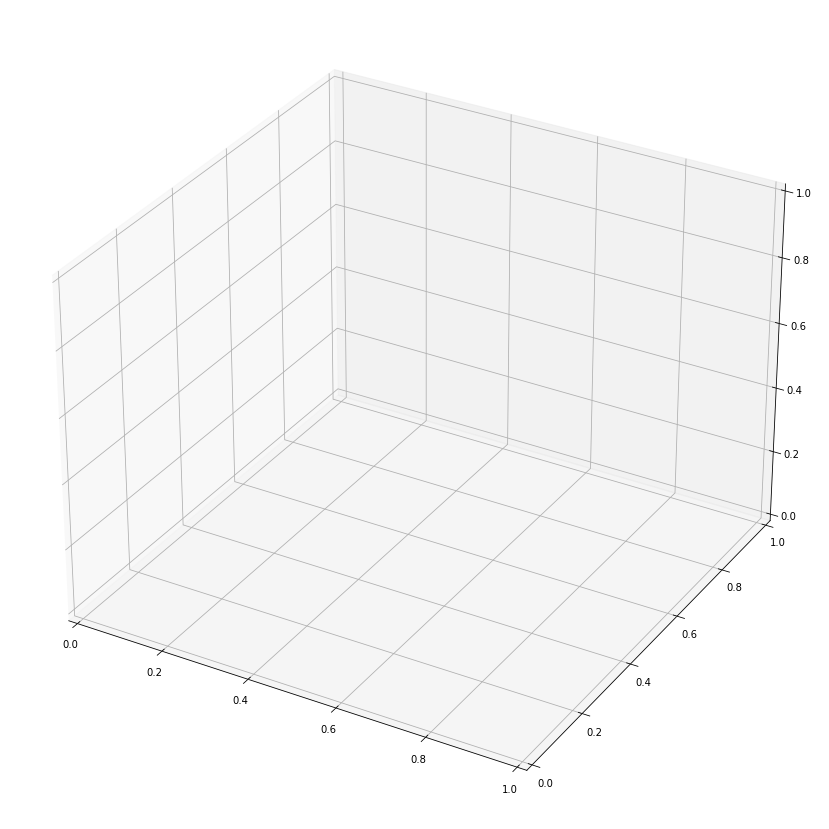

In [22]:
fig = plt.figure(figsize = (20, 15))
ax = plt.axes(projection ="3d")
ax.scatter3D(s1, s2, s3, color=colors[Z])

In [29]:
seqss = []

for file in allFiles[6:7]:
    sequences = []

    for record in SeqIO.parse(DATA_PATH + file, "fastq"):
        if len(record.seq)>50:
            sequences.append(record) # uklanjanje adaptera
    seqss.extend(sequences)



In [30]:
seq_str = []
for seq in seqss:
    if str(seq.seq)[27:-20] in seqs:
        seq_str.append(seq)



In [35]:
print(seq_str)
SeqIO.write(seq_str, "data/aligned_fasta/useqs.fasta","fasta" )

[SeqRecord(seq=Seq('GATCCTCTCTCTGCAGCACATTTCCTGGAGTATGCTAAGAGCGAGTGTCATTTC...GAA'), id='16WBS:00018:00026', name='16WBS:00018:00026', description='16WBS:00018:00026', dbxrefs=[]), SeqRecord(seq=Seq('GATCCTCTCTCTGCAGCACATTTCCTGCTGCATATTAAGGCCGAATGTCATTTC...AAA'), id='16WBS:00034:00042', name='16WBS:00034:00042', description='16WBS:00034:00042', dbxrefs=[]), SeqRecord(seq=Seq('GATCCTCTCTCTGCAGCACATTTCCTGGAGTATCATAAGAGCGAGTGTCATTTC...GAA'), id='16WBS:00035:00047', name='16WBS:00035:00047', description='16WBS:00035:00047', dbxrefs=[]), SeqRecord(seq=Seq('GATCCTCTCTCTGCAGCACATTTTCCTGCTGCATATTAAGGCCGAATGTCATTT...GAA'), id='16WBS:00085:00061', name='16WBS:00085:00061', description='16WBS:00085:00061', dbxrefs=[]), SeqRecord(seq=Seq('GATCCTCTCTCTGCAGCACATTTCCTGGAGTATGCTAAGAGCGAGTGTCATTTC...GAA'), id='16WBS:00094:00146', name='16WBS:00094:00146', description='16WBS:00094:00146', dbxrefs=[]), SeqRecord(seq=Seq('GATCCTCTCTCTGCAGCACATTTCCTGCTGCATATTAAGGCCGAATGTCATTTC...GAA'), id='16WBS:00106:00020

588

In [ ]:
#mafft.bat --out aligned.fasta  --localpair useqs.fasta
#mafft.bat --out aligned.fasta  --inputorder --anysymbol --leavegappyregion --auto useqs.fasta

In [26]:
child = subprocess.Popen(['mafft.bat', '--out', '-'], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
child.stdin.write(seq_str.encode())
child_out = child.communicate()[0].decode('utf8')
seq_ali = list(SeqIO.parse(StringIO(child_out), 'fasta'))
child.stdin.close()

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [16]:
with open('aligned_file.fasta', 'w') as f:
    for seq in seqs:
        f.write( '>' + seq.description + '\n')
        f.write(str(seq.seq) + '\n')

AttributeError: 'str' object has no attribute 'description'

In [15]:
def align_seqs(seqs):
    seq_str = ''
    for seq in seqs:
        seq_str += '>' + seq.description + '\n'
        seq_str += str(seq.seq) + '\n'
    child = subprocess.Popen(['mafft', '--quiet', '-'], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    child.stdin.write(seq_str.encode())
    child_out = child.communicate()[0].decode('utf8')
    seq_ali = list(SeqIO.parse(StringIO(child_out), 'fasta'))
    child.stdin.close()
    return seq_ali

In [28]:
SeqIO.write(useqs, "useqs.fasta","fasta" )

AttributeError: 'str' object has no attribute 'id'

In [44]:
DATA_PATH="data/aligned_fasta/mafft-win/aligned.fasta"
for record in SeqIO.parse(DATA_PATH , "fasta"):
    print(len(record.seq))


428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428


In [47]:
import os
os.system('cmd /c "mafft.bat --out aligned.fasta  --reorder --anysymbol --leavegappyregion --auto useqs.fasta"')

1